# Сравнительный анализ методов детекции основного контента

**Задача:** сравнить три подхода определения таймкодов начала и конца основного контента:
1. Видео-модель (`results/predictions.csv`)
2. Аудио-модель (`results/audio_detection_results.csv`)
3. Комбинированный подход (взвешенное объединение аудио + видео)  

**Данные:**
- Правильные метки: `data/labels.csv`
- Видео-результаты: `results/predictions.csv`
- Аудио-результаты: `results/audio_detection_results.csv`
- Вероятности: `data/audio_probs/*.npy`, `data/video_probs/*.npy`
- Комбинированные результаты сохранятся в `results/combined_results.csv`


In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib
import warnings

warnings.filterwarnings('ignore')
# Настройки визуализации
plt.rcParams['figure.figsize'] = (10, 5)
sns.set_style("whitegrid")

# Параметры комбинированного подхода
AUDIO_WEIGHT = 0.4
VIDEO_WEIGHT = 0.6
THRESHOLD = 0.45
MIN_SEG_LEN = 600  # минимальная длина основного контента (секунд)
TEST_SIZE_EPIS = 3  # скольким эпизодам оставить для валидации
MIN_CONTENT_LEN = 30  # минимальная длина контента (сек)
SEED = 42

# Пути
LABELS_CSV = 'data/labels.csv'
VIDEO_CSV = 'results/predictions.csv'
AUDIO_CSV = 'results/audio_detection_results.csv'
COMBINED_CSV = 'results/combined_results.csv'
AUDIO_DIR = 'data/audio_probs'
VIDEO_DIR = 'data/video_probs'
MODEL_PATH = 'models/combined_rf_model.pkl'

# Создаем папку для комбинированных результатов
os.makedirs(os.path.dirname(COMBINED_CSV), exist_ok=True)

## Загрузка и подготовка данных  
Считаем ground truth и предсказания аудио и видео в DataFrame, приведём имена эпизодов к единому виду.

In [15]:
def to_sec(ts: str):
    h, m, s = ts.split(":")
    return int(h) * 3600 + int(m) * 60 + int(float(s))


gt = pd.read_csv(LABELS_CSV)
# сериал и эпизод
gt["show"] = gt["file"].apply(lambda x: os.path.dirname(x))
gt["episode"] = gt["file"].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
# секунды
gt["true_start"] = gt["start_main"].map(to_sec)
gt["true_end"] = gt["end_main"].map(to_sec)
gt = gt[["show", "episode", "true_start", "true_end"]]
print("GT episodes:", len(gt))

GT episodes: 19


In [16]:
# загрузка видео-предсказаний
vid = pd.read_csv(VIDEO_CSV)
# в predictions.csv уже есть колонка video_id == episode
vid = vid.rename(columns={"video_id": "episode",
                          "pred_start": "video_start",
                          "pred_end": "video_end"})
vid = vid[["episode", "video_start", "video_end"]]
print("Video preds episodes:", len(vid))

Video preds episodes: 19


In [17]:
# загрузка аудио-предсказаний
aud = pd.read_csv(AUDIO_CSV)
# файл audio_detection_results.csv имеет колонки show, episode, intro_end_sec, credits_start_sec
aud = aud.rename(columns={"intro_end_sec": "audio_start",
                          "credits_start_sec": "audio_end"})
# НЕ комбинируем show и episode в одну строку!
aud = aud[["episode", "audio_start", "audio_end"]]
print("Audio preds episodes:", len(aud))

Audio preds episodes: 19


In [18]:
# объединение
df = gt.merge(vid, on="episode", how="inner")
print("После merge GT+Video:", len(df))
df = df.merge(aud, on="episode", how="inner")
print("После merge +Audio:", len(df))
df.head()

После merge GT+Video: 19
После merge +Audio: 19


,show,episode,true_start,true_end,video_start,video_end,audio_start,audio_end
0,show1,downton-abbey-season-1-episode-02,55,2934,54,2939,52,2938
1,show1,downton-abbey-season-1-episode-03,55,2931,56,2931,56,2936
2,show1,downton-abbey-season-1-episode-04,55,2840,54,2839,51,2848
3,show1,downton-abbey-season-1-episode-05,55,2936,55,2939,54,2943
4,show1,downton-abbey-season-1-episode-06,55,2872,55,2870,59,2881


## Генерация комбинированных предсказаний 

Здесь мы обучим простой классификатор (Random Forest) на признаках, полученных из аудио и видео вероятностей, чтобы предсказать поминутные метки «контент / не-контент», а затем из предсказанной маски выделим границы эпизода.  
Результаты сохраняем в `results/combined_results.csv`.

### Загрузка меток и создание масок
Для каждого эпизода строим маску `y[t] = 1` если секунды `t` в пределах основного контента, иначе `0`.

In [21]:
all_data = []
# повторно загрузим labels, добавим show и episode
labels2 = pd.read_csv(LABELS_CSV)
labels2['show'] = labels2['file'].apply(lambda x: os.path.dirname(x))
labels2['episode'] = labels2['file'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
labels2['true_start'] = labels2['start_main'].map(to_sec)
labels2['true_end'] = labels2['end_main'].map(to_sec)

for _, row in tqdm(labels2.iterrows(), total=len(labels2), desc="Build GT"):
    show, ep = row['show'], row['episode']
    # теперь правильно формируем имена
    a_file = os.path.join(AUDIO_DIR, f"p_audio_{show}_{ep}.npy")
    v_file = os.path.join(VIDEO_DIR, f"p_video_{show}_{ep}.npy")
    if not os.path.exists(a_file) or not os.path.exists(v_file):
        continue
    a_p = np.load(a_file)
    v_p = np.load(v_file)
    L = min(len(a_p), len(v_p))
    start, end = row['true_start'], row['true_end']
    for t in range(L):
        label = 1 if (start <= t < end) else 0
        all_data.append((show, ep, t, a_p[t], v_p[t], label))

df_feat = pd.DataFrame(all_data,
                       columns=['show', 'episode', 't', 'audio_p', 'video_p', 'y'])
print("Total samples:", len(df_feat))

Build GT:   0%|          | 0/19 [00:00<?, ?it/s]

Total samples: 334206


### Формирование признаков и разбиение на train/test

In [23]:
# Признаки и split
from sklearn.model_selection import GroupShuffleSplit

# создаём новые признаки
df_feat['diff_audio'] = df_feat.groupby('episode')['audio_p'].diff().fillna(0)
df_feat['diff_video'] = df_feat.groupby('episode')['video_p'].diff().fillna(0)
df_feat['sum_p'] = df_feat['audio_p'] + df_feat['video_p']
df_feat['prod_p'] = df_feat['audio_p'] * df_feat['video_p']

# train/test по эпизодам (чтобы не было утечки)
gss = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE_EPIS / len(labels), random_state=SEED)
train_idx, test_idx = next(gss.split(df_feat, groups=df_feat['episode']))
X_cols = ['audio_p', 'video_p', 'diff_audio', 'diff_video', 'sum_p', 'prod_p']
X_train = df_feat.loc[train_idx, X_cols]
y_train = df_feat.loc[train_idx, 'y']
X_test = df_feat.loc[test_idx, X_cols]
y_test = df_feat.loc[test_idx, 'y']

### Обучение RandomForestClassifier

In [27]:
# Обучаем модель
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=SEED,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Сохраняем модель
joblib.dump(rf, MODEL_PATH)

# Получаем отчёт в виде словаря и преобразуем в DataFrame
report_dict = classification_report(
    y_test,
    y_pred,
    digits=3,
    output_dict=True  # <— ключевой аргумент, чтобы вернуть структуру, а не строку
)
report_df = pd.DataFrame(report_dict).T  # транспонируем для удобства

report_df

,precision,recall,f1-score,support
0,1.000000,0.989247,0.994595,279.000000
1,0.999640,1.000000,0.999820,8329.000000
accuracy,0.999651,0.999651,0.999651,0.999651
macro avg,0.999820,0.994624,0.997207,8608.000000
weighted avg,0.999652,0.999651,0.999651,8608.000000


### Прогон модели по всем эпизодам и выделение сегментов

In [30]:
# Предсказание и сегментация
rf = joblib.load(MODEL_PATH)
combined_results = []

for ep, grp in tqdm(df_feat.groupby('episode'), desc="Inference"):
    # сбор признаков
    X = grp[X_cols].values
    p = rf.predict_proba(X)[:, 1]  # вероятность контента
    # сглаживаем 5-секундным средним
    p_smooth = pd.Series(p).rolling(5, center=True, min_periods=1).mean().values
    # бинарная маска
    mask = p_smooth > 0.5
    # находим границы самого длинного True-блока
    best = (0, 0);
    cur = None
    for i, v in enumerate(mask):
        if v and cur is None:
            cur = i
        if not v and cur is not None:
            if i - cur > best[1] - best[0]:
                best = (cur, i - 1)
            cur = None
    if cur is not None and len(mask) - cur > best[1] - best[0]:
        best = (cur, len(mask) - 1)
    s_pred, e_pred = best
    combined_results.append({'episode': ep, 'comb_start': s_pred, 'comb_end': e_pred})

comb_df = pd.DataFrame(combined_results)
comb_df.to_csv(COMBINED_CSV, index=False)
print(f"Saved combined results to {COMBINED_CSV}")
comb_df.head()

Inference:   0%|          | 0/19 [00:00<?, ?it/s]

Saved combined results to results/combined_results.csv


,episode,comb_start,comb_end
0,Mad.Men.S01E01.720p.BluRay.2CH.x264-PSA,47,2872
1,Mad.Men.S01E02.720p.BluRay.2CH.x264-PSA,40,2769
2,Mad.Men.S01E03.720p.BluRay.2CH.x264-PSA,39,2602
3,Mad.Men.S01E04.720p.BluRay.2CH.x264-PSA,39,2659
4,Mad.Men.S01E05.720p.BluRay.2CH.x264-PSA,38,2829


### Проверка точности комбинированного подхода

In [31]:
# Оценка MAE по комбинированным результатам
res = comb_df.merge(labels[['episode', 'true_start', 'true_end']], on='episode')
res['err_start'] = (res['comb_start'] - res['true_start']).abs()
res['err_end'] = (res['comb_end'] - res['true_end']).abs()print("Combined MAE start:", res['err_start'].mean())
print("Combined MAE end:  ", res['err_end'].mean())

Combined MAE start: 0.15789473684210525
Combined MAE end:   0.7368421052631579


## Объединение всех трёх подходов и вычисление ошибок  
Считаем абсолютную ошибку начала и конца для видео, аудио и комбинированного подхода.

In [32]:
# Merge и расчёт ошибок
df = df.merge(comb_df, on='episode', how='left')
# вычисляем ошибки
for m in ['video', 'audio', 'comb']:
    df[f'{m}_err_start'] = (df[f'{m}_start'] - df['true_start']).abs()
    df[f'{m}_err_end'] = (df[f'{m}_end'] - df['true_end']).abs()

# таблица с метриками
metrics = {}
for m in ['video', 'audio', 'comb']:
    metrics[m] = {
        'MAE_start': df[f'{m}_err_start'].mean(),
        'MAE_end': df[f'{m}_err_end'].mean(),
        'STD_start': df[f'{m}_err_start'].std(),
        'STD_end': df[f'{m}_err_end'].std(),
        'Hit±3_start': (df[f'{m}_err_start'] <= 3).mean(),
        'Hit±3_end': (df[f'{m}_err_end'] <= 3).mean()
    }
metrics_df = pd.DataFrame(metrics).T
metrics_df

,MAE_start,MAE_end,STD_start,STD_end,Hit±3_start,Hit±3_end
video,0.473684,1.631579,0.512989,1.640140,1.000000,0.894737
audio,2.421053,7.105263,1.017393,1.696229,0.842105,0.000000
comb,0.157895,0.736842,0.374634,0.452414,1.000000,1.000000


## Визуализация распределений ошибок  
Построим гистограммы и boxplot для начала и конца контента.

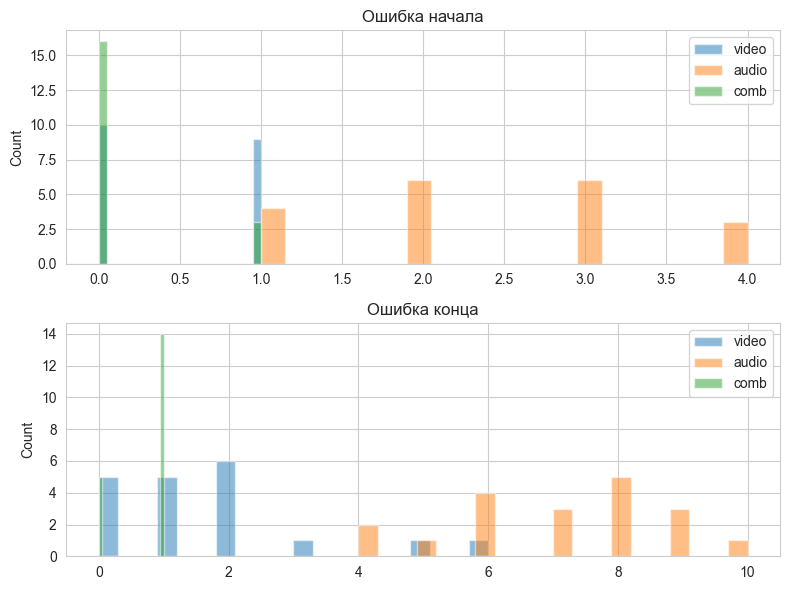

In [33]:
# Гистограммы ошибок
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
for m, color in zip(['video', 'audio', 'comb'], ['C0', 'C1', 'C2']):
    axes[0].hist(df[f'{m}_err_start'].dropna(), bins=20, alpha=0.5, label=m, color=color)
    axes[1].hist(df[f'{m}_err_end'].dropna(), bins=20, alpha=0.5, label=m, color=color)
axes[0].set(title='Ошибка начала', ylabel='Count')
axes[1].set(title='Ошибка конца', ylabel='Count')
for ax in axes: ax.legend(), ax.grid(True)
plt.tight_layout()
plt.show()

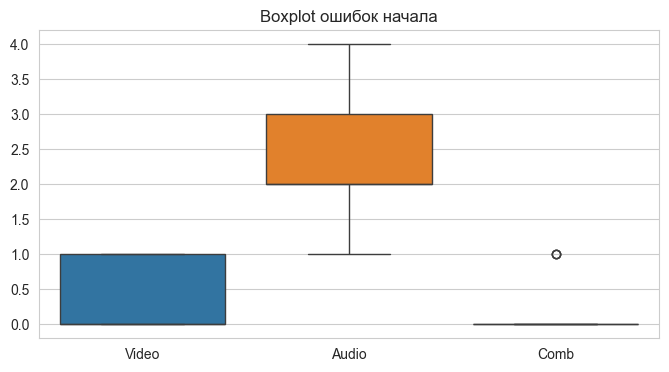

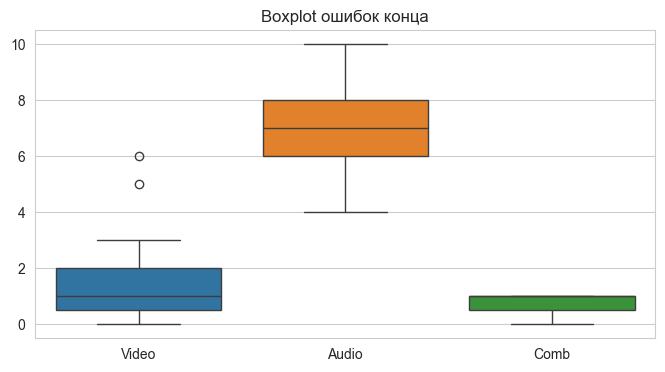

In [34]:
# Boxplot ошибок
plt.figure(figsize=(8, 4))
sns.boxplot(data=df[[f'{m}_err_start' for m in ['video', 'audio', 'comb']]])
plt.title('Boxplot ошибок начала');
plt.xticks([0, 1, 2], ['Video', 'Audio', 'Comb']);
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(data=df[[f'{m}_err_end' for m in ['video', 'audio', 'comb']]])
plt.title('Boxplot ошибок конца');
plt.xticks([0, 1, 2], ['Video', 'Audio', 'Comb']);
plt.show()

## Пример детальной визуализации для одного эпизода  
Выберем эпизод и покажем кривые вероятностей для аудио, видео и комбинированной модели.

Эпизод: show1/downton-abbey-season-1-episode-02


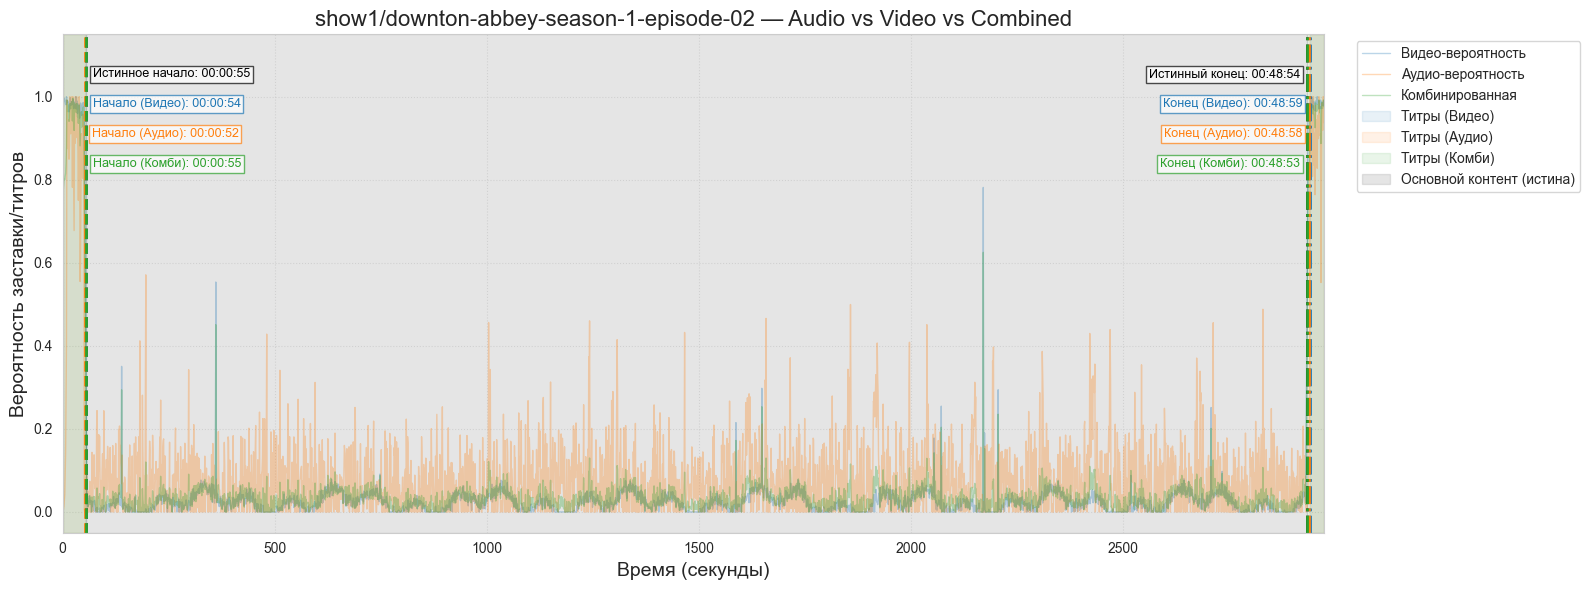

In [60]:
import matplotlib.transforms as mtransforms

# Цветовая палитра
LUT_COLOR = {
    'audio': 'C1',
    'video': 'C0',
    'comb': 'C2',
    'truth': 'black'
}

row = df.iloc[0]
show, episode = row['show'], row['episode']
print(f"Эпизод: {show}/{episode}")

# Загрузка массивов вероятностей
a_path = os.path.join(AUDIO_DIR, f"p_audio_{show}_{episode}.npy")
v_path = os.path.join(VIDEO_DIR, f"p_video_{show}_{episode}.npy")
a_p = np.load(a_path)
v_p = np.load(v_path)

L = min(len(a_p), len(v_p))
t = np.arange(L)
c_p = AUDIO_WEIGHT * a_p[:L] + VIDEO_WEIGHT * v_p[:L]

# Собираем все границы в словарь
bounds = {
    'truth_start': row['true_start'], 'truth_end': row['true_end'],
    'video_start': row['video_start'], 'video_end': row['video_end'],
    'audio_start': row['audio_start'], 'audio_end': row['audio_end'],
    'comb_start': row['comb_start'], 'comb_end': row['comb_end']
}


# Вспомогательная функция для форматирования времени
def sec2hhmm(sec):
    m, s = divmod(int(sec), 60)
    h, m = divmod(m, 60)
    return f"{h:02d}:{m:02d}:{s:02d}"


# Построение графика
fig, ax = plt.subplots(figsize=(16, 6))

# 1) Кривые вероятностей
ax.plot(t, v_p[:L], alpha=0.3, lw=1, color=LUT_COLOR['video'], label='Видео-вероятность')
ax.plot(t, a_p[:L], alpha=0.3, lw=1, color=LUT_COLOR['audio'], label='Аудио-вероятность')
ax.plot(t, c_p, alpha=0.3, lw=1, color=LUT_COLOR['comb'], label='Комбинированная')

# 2) Закрашенные зоны титров и основного контента
ax.axvspan(0, bounds['video_start'], alpha=0.1, color=LUT_COLOR['video'])
ax.axvspan(bounds['video_end'], L, alpha=0.1, color=LUT_COLOR['video'], label='Титры (Видео)')

ax.axvspan(0, bounds['audio_start'], alpha=0.1, color=LUT_COLOR['audio'])
ax.axvspan(bounds['audio_end'], L, alpha=0.1, color=LUT_COLOR['audio'], label='Титры (Аудио)')

ax.axvspan(0, bounds['comb_start'], alpha=0.1, color=LUT_COLOR['comb'])
ax.axvspan(bounds['comb_end'], L, alpha=0.1, color=LUT_COLOR['comb'], label='Титры (Комби)')

ax.axvspan(bounds['truth_start'],
           bounds['truth_end'],
           alpha=0.2, color='grey', label='Основной контент (истина)')

# 3) Вертикальные линии для всех границ
for key, x in bounds.items():
    prefix = key.split('_')[0]  # 'truth','video','audio','comb'
    color = LUT_COLOR.get(prefix, 'grey')
    style = '--' if key.endswith('start') else '-.'
    ax.axvline(x, color=color, linestyle=style, linewidth=2)

# 4) Подписи возле линий внутри графика, с отступом
# Базовый трансформ: X=data, Y=axes fraction
base_trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

# Списки меток
start_labels = [
    ('truth_start', 'Истинное начало'),
    ('video_start', 'Начало (Видео)'),
    ('audio_start', 'Начало (Аудио)'),
    ('comb_start', 'Начало (Комби)')
]
end_labels = [
    ('truth_end', 'Истинный конец'),
    ('video_end', 'Конец (Видео)'),
    ('audio_end', 'Конец (Аудио)'),
    ('comb_end', 'Конец (Комби)')
]

# Вертикальные позиции (доля от оси)
y0_start, dy = 0.92, -0.06
y0_end, de = 0.92, -0.06

# Рисуем начальные метки, сдвигая вправо на 5 пунктов
for i, (key, text) in enumerate(start_labels):
    x = bounds[key]
    y = y0_start + i * dy
    color = LUT_COLOR[key.split('_')[0]]
    offset_trans = mtransforms.offset_copy(base_trans, fig=fig, x=5, y=0, units='points')
    ax.text(
        x, y,
        f"{text}: {sec2hhmm(x)}",
        transform=offset_trans,
        ha='left', va='center',
        color=color, fontsize=9,
        bbox=dict(facecolor='white', edgecolor=color, alpha=0.7, pad=2)
    )

# Рисуем конечные метки, сдвигая влево на 5 пунктов
for i, (key, text) in enumerate(end_labels):
    x = bounds[key]
    y = y0_end + i * de
    color = LUT_COLOR[key.split('_')[0]]
    offset_trans = mtransforms.offset_copy(base_trans, fig=fig, x=-5, y=0, units='points')
    ax.text(
        x, y,
        f"{text}: {sec2hhmm(x)}",
        transform=offset_trans,
        ha='right', va='center',
        color=color, fontsize=9,
        bbox=dict(facecolor='white', edgecolor=color, alpha=0.7, pad=2)
    )

# 5) Оформление
ax.set_title(f"{show}/{episode} — Audio vs Video vs Combined", fontsize=16)
ax.set_xlabel("Время (секунды)", fontsize=14)
ax.set_ylabel("Вероятность заставки/титров", fontsize=14)
ax.set_xlim(0, L)
ax.set_ylim(-0.05, 1.15)
ax.grid(True, linestyle=':', alpha=0.5)

# Легенда (собираем уникальные метки)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)

# Сохраняем и отображаем
plt.tight_layout()
plt.savefig(RESULTS_DIR / f'comparison_clear_{show}_{episode}.png', dpi=150, bbox_inches='tight')
plt.show()

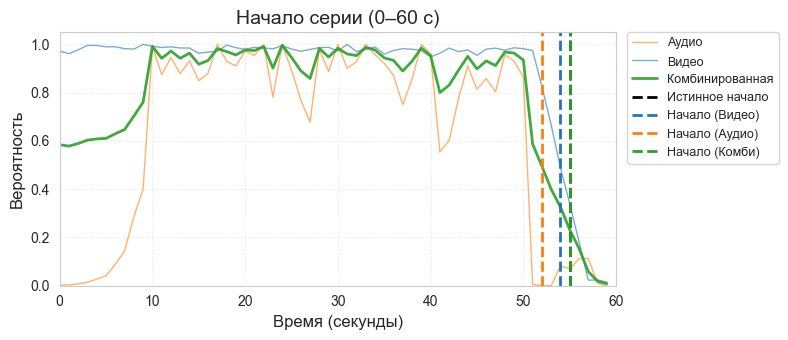

In [45]:
# Увеличенный взгляд на начало серии (первые 60 сек)
fig, ax = plt.subplots(figsize=(8, 3.5))
ax.plot(t[:60], a_p[:60], alpha=0.6, lw=1, label='Аудио', color='C1')
ax.plot(t[:60], v_p[:60], alpha=0.6, lw=1, label='Видео', color='C0')
ax.plot(t[:60], c_p[:60], alpha=0.9, lw=2, label='Комбинированная', color='C2')
ax.axvline(ts, color='black', linestyle='--', lw=2, label='Истинное начало')
ax.axvline(vs, color='C0', linestyle='--', lw=2, label='Начало (Видео)')
ax.axvline(as_, color='C1', linestyle='--', lw=2, label='Начало (Аудио)')
ax.axvline(cs, color='C2', linestyle='--', lw=2, label='Начало (Комби)')

ax.set_title("Начало серии (0–60 с)", fontsize=14)
ax.set_xlabel("Время (секунды)", fontsize=12)
ax.set_ylabel("Вероятность", fontsize=12)
ax.set_xlim(0, 60)
ax.set_ylim(0, 1.05)
ax.grid(True, ls=':', alpha=0.5)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          bbox_to_anchor=(1.02, 1), loc='upper left',
          borderaxespad=0, fontsize=9)

plt.tight_layout()
plt.show()

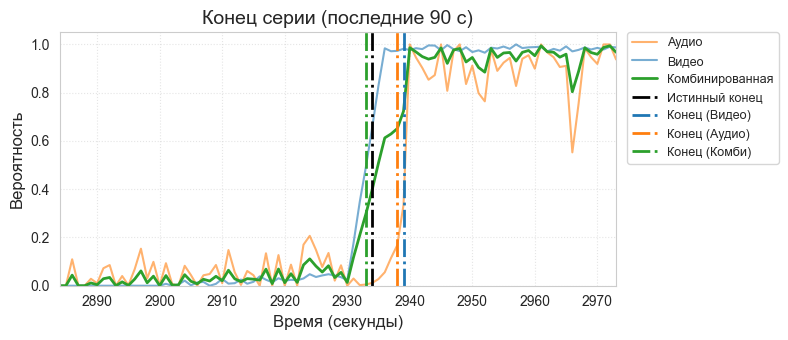

In [46]:
# Увеличенный взгляд на конец серии (последние 90 сек + титры)
fig, ax = plt.subplots(figsize=(8, 3.5))
end_window = 90
start_idx = max(0, L - end_window)
tx = t[start_idx:]
ap = a_p[start_idx:start_idx + len(tx)]
vp = v_p[start_idx:start_idx + len(tx)]
cp = c_p[start_idx:start_idx + len(tx)]

ax.plot(tx, ap, label='Аудио', color='C1', alpha=0.6)
ax.plot(tx, vp, label='Видео', color='C0', alpha=0.6)
ax.plot(tx, cp, label='Комбинированная', color='C2', lw=2)
ax.axvline(te, color='black', linestyle='-.', lw=2, label='Истинный конец')
ax.axvline(ve, color='C0', linestyle='-.', lw=2, label='Конец (Видео)')
ax.axvline(ae_, color='C1', linestyle='-.', lw=2, label='Конец (Аудио)')
ax.axvline(ce, color='C2', linestyle='-.', lw=2, label='Конец (Комби)')

ax.set_title("Конец серии (последние 90 с)", fontsize=14)
ax.set_xlabel("Время (секунды)", fontsize=12)
ax.set_ylabel("Вероятность", fontsize=12)
ax.set_xlim(tx.min(), tx.max())
ax.set_ylim(0, 1.05)
ax.grid(True, ls=':', alpha=0.5)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          bbox_to_anchor=(1.02, 1), loc='upper left',
          borderaxespad=0, fontsize=9)

plt.tight_layout()
plt.show()

## Сохранение итоговых таблиц  
Сохраним полный DataFrame с ошибками и сводную метрику.

In [40]:
os.makedirs('results', exist_ok=True)
df.to_csv('results/full_comparison_results.csv', index=False)
metrics_df.to_csv('results/summary_metrics.csv')

In [41]:
df

,show,episode,true_start,true_end,video_start,video_end,audio_start,audio_end,comb_start,comb_end,video_err_start,video_err_end,audio_err_start,audio_err_end,comb_err_start,comb_err_end
0,show1,downton-abbey-season-1-episode-02,55,2934,54,2939,52,2938,55,2933,1,5,3,4,0,1
1,show1,downton-abbey-season-1-episode-03,55,2931,56,2931,56,2936,55,2931,1,0,1,5,0,0
2,show1,downton-abbey-season-1-episode-04,55,2840,54,2839,51,2848,55,2839,1,1,4,8,0,1
3,show1,downton-abbey-season-1-episode-05,55,2936,55,2939,54,2943,55,2935,0,3,1,7,0,1
4,show1,downton-abbey-season-1-episode-06,55,2872,55,2870,59,2881,55,2871,0,2,4,9,0,1
5,show1,downton-abbey-season-1-episode-07,55,3876,55,3874,56,3882,55,3875,0,2,1,6,0,1
6,show2,Mad.Men.S01E01.720p.BluRay.2CH.x264-PSA,48,2873,48,2879,50,2880,47,2872,0,6,2,7,1,1
7,show2,Mad.Men.S01E02.720p.BluRay.2CH.x264-PSA,40,2770,41,2770,39,2778,40,2769,1,0,1,8,0,1
8,show2,Mad.Men.S01E03.720p.BluRay.2CH.x264-PSA,39,2602,39,2603,37,2612,39,2602,0,1,2,10,0,0
9,show2,Mad.Men.S01E04.720p.BluRay.2CH.x264-PSA,39,2659,40,2660,42,2666,39,2659,1,1,3,7,0,0


In [42]:
metrics_df

,MAE_start,MAE_end,STD_start,STD_end,Hit±3_start,Hit±3_end
video,0.473684,1.631579,0.512989,1.640140,1.000000,0.894737
audio,2.421053,7.105263,1.017393,1.696229,0.842105,0.000000
comb,0.157895,0.736842,0.374634,0.452414,1.000000,1.000000
